In [1]:
## imports
import numpy as np
from matplotlib import pyplot as plt
from struct import unpack
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import norm
from scipy.optimize import curve_fit
from astropy import modeling
import time
import numpy.matlib
%matplotlib widget

In [2]:
lines_of_data = 512

filename = 'C:/SPAD_ARRAY/release_2208/mainstream/Data/11-4-2022/acq_221104_10'

In [3]:
# Read data file 
# data used from picosecond laser
st = time.time()

rawFile = np.fromfile(filename, dtype=np.uint32)  # read data 
data = (rawFile & 0xFFFFFFF).astype(np.longlong)*1.0 #17.857 # Multiply with the lowes bin
data[np.where(rawFile < 0x80000000)] = -1 # Mask not valid data 
nmrCycles = int(len(data) / lines_of_data / 256)  # number of cycles,
data_matrix = data.reshape((lines_of_data,nmrCycles*256), order='F').reshape((lines_of_data, 256,-1),order='F').transpose((0,2,1)).reshape((-1, 256),order='F').transpose() # reshape the matrix
    
et = time.time()
print('Execution time:', et - st, 'seconds')

Execution time: 0.024003028869628906 seconds


In [4]:
# Optional TDC calibration IF USING THIS OPTION CHANGE THE PREVIOUS CODE TO data = (rawFile & 0xFFFFFFF).astype(np.longlong)*1.0 instead od 17.857
tdccal_arr = np.load('tdccal_arr.npy')

timestampsnmr = lines_of_data
nmr_of_cycles = int(len(data_matrix[0,:]) / timestampsnmr)

offsets = np.zeros(256)

for i in range(256):
    ind = np.argwhere(data_matrix[i,:] >= 0)
    data_matrix[i,ind] = (data_matrix[i,ind] - (data_matrix[i,ind] % 140))*17.857 +  tdccal_arr[i,(data_matrix[i,ind] % 140).astype(int)] + offsets[i]

In [5]:
# creates a list of arrays that contains positions of coincident peaks 
print('start',time.ctime())

def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


#pixel_combinations = []
peak_positions = np.zeros((4,64))

p_0 = [0,64,128,192]

for k in range(4):
    print(k,time.ctime())
    for i in range(1+64*k,64+64*k):
        #print(i,time.ctime())
        p0 = p_0[k]
        p1 = i

        pixel_0 = data_matrix[p0]
        pixel_1 = data_matrix[p1]

        timewindow = 30000
        timestampsnmr = lines_of_data
        nmr_of_cycles = int(len(pixel_0) / timestampsnmr)
        delta_t = []

        # start = time.time()
        for cycle in range(nmr_of_cycles):
            for timestamp_pix0 in range(timestampsnmr):
                pix_0 = pixel_0[cycle * timestampsnmr + timestamp_pix0]
                if pix_0 == -1:
                    break
                for timestamp_pix1 in range(timestampsnmr):
                    pix_1=pixel_1[cycle * timestampsnmr + timestamp_pix1]
                    if pix_1 == -1 or pix_1 == 0:
                        break
                    if np.abs(pix_0 - pix_1) < timewindow:
                        delta_t.append(pix_0 - pix_1)
                    else:
                        continue
        #print(len(delta_t))
        bins = np.arange(np.min(delta_t), np.max(delta_t), 17.857)

        counts, binEdges=np.histogram(delta_t,bins=bins)
        binCenters = 0.5*(binEdges[1:]+binEdges[:-1])

        n_max = np.argmax(counts)
        arg_max = (binEdges[n_max] + binEdges[n_max + 1]) / 2
        sigma = 200

        parameters, covariance = curve_fit(gauss, binCenters, counts,p0=[max(counts), arg_max, sigma])

        fit_y = gauss(binCenters, parameters[0], parameters[1], parameters[2])
        peak_positions[k][i-64*k-1] = parameters[1]
        #peak_positions[k] = np.concatenate((peak_positions[k], parameters[1]),axis=None)
        #peak_positions[k] = np.append(peak_positions[k],0)
        #pixel_combinations = np.concatenate((pixel_combinations, str(j)+','+str(i)),axis=None)

print('end',time.ctime())

start Thu Dec  1 18:49:00 2022
0 Thu Dec  1 18:49:00 2022
1 Thu Dec  1 18:49:10 2022
2 Thu Dec  1 18:49:41 2022
3 Thu Dec  1 18:51:22 2022
end Thu Dec  1 18:52:04 2022


In [6]:
print(peak_positions.shape)
print(peak_positions)

(4, 64)
[[ 2140.69258244  -359.41484012  1876.18724396 -1593.23320593
  -5571.37723727 -2997.84319217 -2328.38229598 -3223.06661539
     24.18967572 -5002.45247442 -4147.70544193  2869.01815212
  -2701.0465584  -1870.4141249  -1837.67253377 -2208.45610715
  -5269.84858423  3309.51789275 -1251.59295289  -486.24179243
   1977.3687748  -1877.39185845 -1183.72558165   704.04716883
  -4565.8544689  -1302.5998136    161.76911346 -1546.49239464
   -698.9466406  -1596.89977395   968.46744726 -2273.7457257
   2537.81012988 -2881.26173995 -1826.07625805   148.23578093
   1572.39462337 -4956.23440201 -1482.59365081 -1806.76467986
  -3401.09590923 -3190.73585922 -1195.74751675  -194.91178049
   -674.89205441 -2166.47289227 -4403.10823073  -795.81165579
  -7423.09027739  -950.67065392  -588.27231088 -2496.00935586
  -4001.55382449 -3746.58405876 -4643.59588766  1553.93148319
   -143.98646329  -308.19051885 -4558.35719426 -3643.33929104
  -1646.35474464   260.61215343 -3055.75044371     0.        ]


In [7]:
# creates matrix for system of equations
a = np.zeros((64,64))
for i in range(0,63):
    a[i][0] = 1
    a[i][i+1] = -1
    a[-1] = 1

In [8]:
print(a)

[[ 1. -1.  0. ...  0.  0.  0.]
 [ 1.  0. -1. ...  0.  0.  0.]
 [ 1.  0.  0. ...  0.  0.  0.]
 ...
 [ 1.  0.  0. ...  0. -1.  0.]
 [ 1.  0.  0. ...  0.  0. -1.]
 [ 1.  1.  1. ...  1.  1.  1.]]


In [9]:
# calculates offsets of each pixel
offsets_arr = []
for i in range(0,4):
    offsets = np.linalg.solve(a,peak_positions[i])
    offsets_arr = np.concatenate((offsets_arr,offsets),axis=None)
print(offsets_arr)

[-1.59330662e+03 -3.73399920e+03 -1.23389178e+03 -3.46949386e+03
 -7.34135512e-02  3.97807062e+03  1.40453657e+03  7.35075677e+02
  1.62976000e+03 -1.61749630e+03  3.40914585e+03  2.55439882e+03
 -4.46232477e+03  1.10773994e+03  2.77107505e+02  2.44365914e+02
  6.15149488e+02  3.67654196e+03 -4.90282451e+03 -3.41713667e+02
 -1.10706483e+03 -3.57067539e+03  2.84085239e+02 -4.09581038e+02
 -2.29735379e+03  2.97254785e+03 -2.90706806e+02 -1.75507573e+03
 -4.68142248e+01 -8.94359979e+02  3.59315447e+00 -2.56177407e+03
  6.80439106e+02 -4.13111675e+03  1.28795512e+03  2.32769639e+02
 -1.74154240e+03 -3.16570124e+03  3.36292778e+03 -1.10712969e+02
  2.13458060e+02  1.80778929e+03  1.59742924e+03 -3.97559103e+02
 -1.39839484e+03 -9.18414565e+02  5.73166273e+02  2.80980161e+03
 -7.97494964e+02  5.82978366e+03 -6.42635966e+02 -1.00503431e+03
  9.02702736e+02  2.40824721e+03  2.15327744e+03  3.05028927e+03
 -3.14723810e+03 -1.44932016e+03 -1.28511610e+03  2.96505057e+03
  2.05003267e+03  5.30481

In [10]:
print(np.average(offsets_arr))
print(offsets_arr.size)

0.0
256


In [11]:
# saves array of pixel offsets
np.save('offsets_arr.npy',offsets_arr)

In [12]:
## Compute delta t for two pixels 

# Set peak postion

p0 = 23
p1 = 40

pixel_0 = data_matrix[p0]
pixel_1 = data_matrix[p1]

ind = np.argwhere(pixel_0 >= 0)
pixel_0[ind] = pixel_0[ind] - offsets_arr[p0]

ind = np.argwhere(pixel_1 >= 0)
pixel_1[ind] = pixel_1[ind] - offsets_arr[p1]

timewindow = 30000
timestampsnmr = lines_of_data
nmr_of_cycles = int(len(pixel_0) / timestampsnmr)
delta_t = []

# start = time.time()
for cycle in range(nmr_of_cycles):
    for timestamp_pix0 in range(timestampsnmr):
        pix_0 = pixel_0[cycle * timestampsnmr + timestamp_pix0]
        if pix_0 == -1:
            break
        for timestamp_pix1 in range(timestampsnmr):
            pix_1=pixel_1[cycle * timestampsnmr + timestamp_pix1] 
            if pix_1 == -1 or pix_1 == 0:
                break
            if np.abs(pix_0 - pix_1) < timewindow:
                delta_t.append(pix_0 - pix_1)
            else:
                continue

NMR of coincidences in window: 125


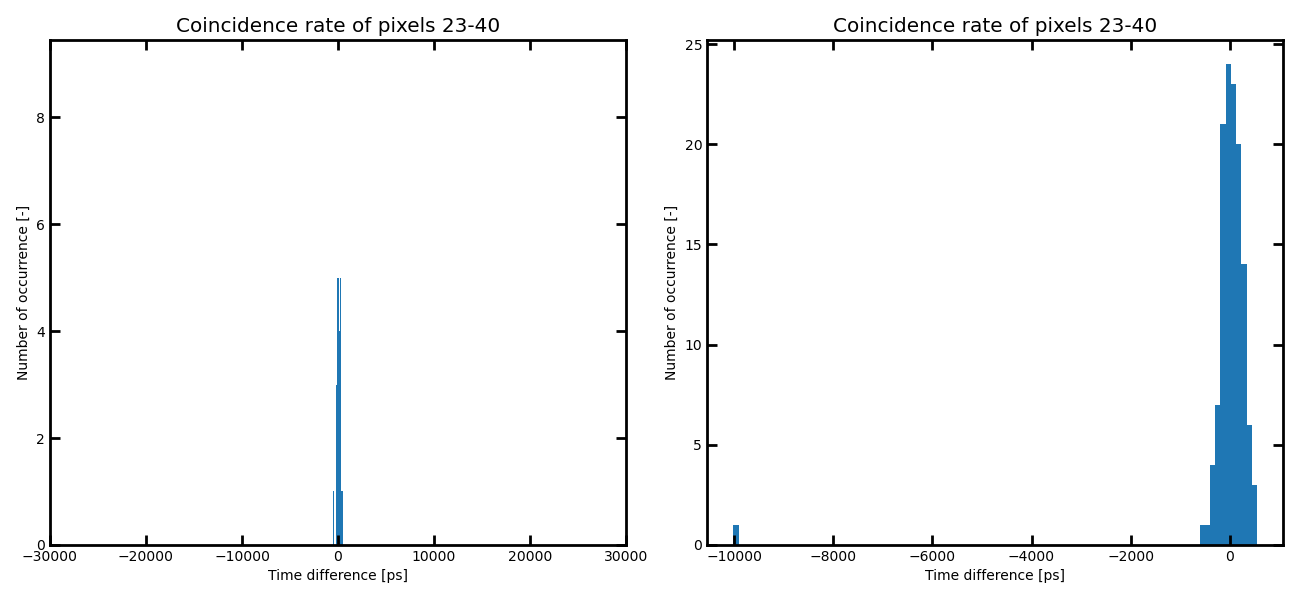

In [13]:
fig, ax = plt.subplots(1,2,figsize=(8,10))

plt.rcParams.update({"font.size": 12})
x = np.arange(0, 256, 1)

plt.xlabel("Pixel [-]")
plt.ylabel("Valid timestamps [-]")

plt.box(bool(1))
plt.grid(False)
plt.subplots_adjust(left=0.15)
fig.set_size_inches(13, 6)

for i in range(2):
    ax[i].tick_params(which="both", width=2, direction="in")
    ax[i].tick_params(which="major", length=7, direction="in")
    ax[i].tick_params(which="minor", length=4, direction="in")
    ax[i].yaxis.set_ticks_position("both")
    ax[i].xaxis.set_ticks_position("both")
    ax[i].set_xlabel("Time difference [ps]")
    ax[i].set_ylabel("Number of occurrence [-]")
    ax[i].set_title("Coincidence rate of pixels {}-{}".format(p0,p1))
    
for axis in ["top", "bottom", "left", "right"]:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)

bins = np.arange(np.min(delta_t), np.max(delta_t), 17.857) #
bins = 100
bins2 = np.arange(np.min(delta_t), np.max(delta_t), 50 )
ax[0].hist(delta_t, bins=500)
ax[1].hist(delta_t, bins=bins)
ax[0].set_xlim(-timewindow, timewindow)

# Set limits of right plot
#ax[1].set_xlim(-4500, -4400)

fig.tight_layout(pad=1.0)

print("NMR of coincidences in window: " + str(len(delta_t)))

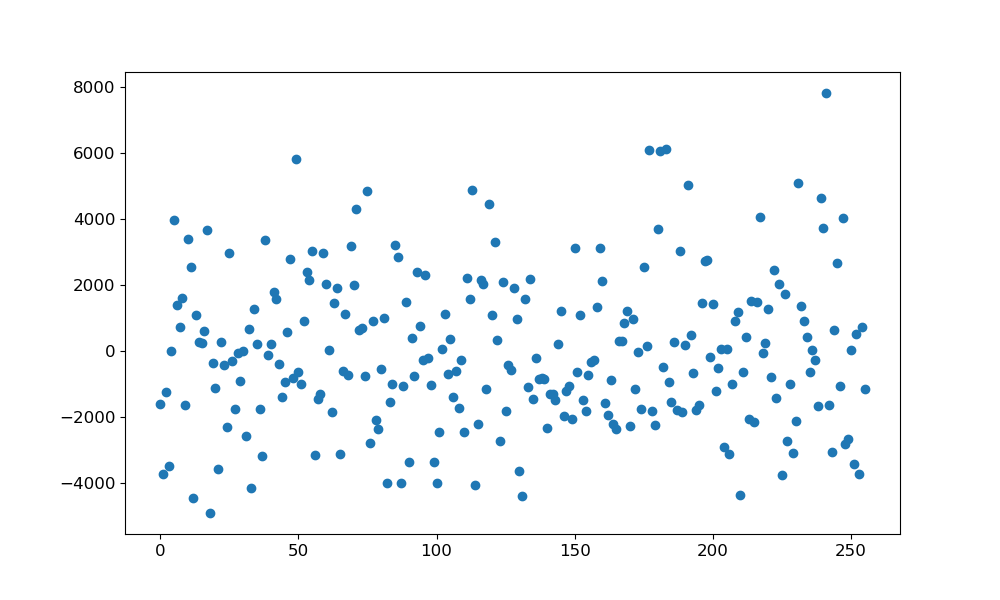

In [14]:
x_axis = np.arange(256)
fig,ax = plt.subplots(figsize = (10,6))
ax.scatter(x_axis,offsets_arr)